# Loan Defaults Modelling

The notebook aims to find the model that offers the best performance in __predicting loan defaults__. 

The primary metric used to evaluate model performance is the __F1 Score__, which is the harmonic mean between precision and recall. The rationale for choosing F1 is that we want to __identify as many defaults as possible while ensuring that our model is not over predicting the defaults__. Additionally, we will provide insgihts about the model performances in relation to its __precision__ and __recall__ and how different use cases may favour different models.

From our exploratory data analysis, we note that we are working with an __imbalanced dataset__. Therefore, we will be applying different __resampling techniques__ and monitor if there are improvements to the model's performance.

__Note__: The functions used in this notebook can be found in the scripts within the utils folder.

## Table of Contents <a id='table_contents'></a>

#### Machine Learning Models

* [Naive Model](#naive)
* [Nearest Centroid](#ncc) 
* [K-Nearest Neighbours](#knn)
* [Logistic Regression](#logreg)

### Importing Libraries

In [1]:
# Standard Tools
from scipy import stats
import pandas as pd
import numpy as np
import warnings
import pickle
import copy
warnings.filterwarnings('ignore')

# Custom Functions
from utils import visualisation as viz
from utils import modelling as mod

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

# Sampling Tools
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.style.use('seaborn-muted')

# Misc
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%config InlineBackend.figure_formate = 'retina'

# Random State
SEED = 8888
np.random.seed(8888)

### Loading Our Processed Data

In [2]:
with open('training_cleaned.pickle', 'rb') as f:
    train = pickle.load(f)

with open('testing_cleaned.pickle', 'rb') as f:
    test = pickle.load(f)

### Splitting Data into Training and Testing Datasets

The dataset will be split into __training (80%)__ and __holdout (20%)__ datasets. 

__Model training and hyper paramter tuning__ will be performed using the training data and using __5-fold cross validation__. We will then compare the performance of different models on the holdout dataset.

In [3]:
X = train.drop('default_status', axis=1)
y = train.default_status

In [4]:
# stratified data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [5]:
# defining cross-validation method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [6]:
# kwargs for cross_validate method
cv_kwargs = {
    'scoring' : 'f1',
    'cv' : skf,
    'n_jobs' : -1,
    'return_train_score' : True,
    'verbose' : False,
    'return_estimator' : True
}

## Baseline Model : Nearest Centroid Classifier <a id='ncc'></a>

The Nearest Centroid Classifier is a simple algorithm that represents each class by the __centroid of its members__, similar to the label updating phase of the K-Means algorithm. Furthermore, there are __no parameters to choose from__, making it a __good baseline classifier__.

In [7]:
# ncc model pipeline
ncc_pipe = Pipeline(steps=[
    ('Standardise',  StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

Cross Validation Results Summary
Avg Training score 	 0.630980
Avg Testing score 	 0.624498

Avg Fitting Time 	 0.0063s
Avg Scoring Time 	 0.0033s


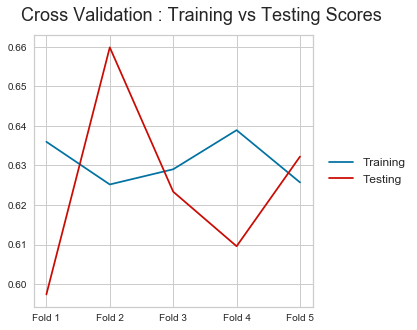

In [8]:
# cross validation summary report
ncc_cv_results = mod.cross_validation_summary(ncc_pipe, X_train, y_train, cv_kwargs, flip_scores=False)

Our baseline model has an __approximate 62% F1 Score__. We will save the estimator that performed the best during cross validation and test it on the holdout dataset.

Holdout Dataset Classification Report for Nearest Centroid
              precision    recall  f1-score   support

           0       0.86      0.67      0.76       326
           1       0.53      0.77      0.63       155

    accuracy                           0.70       481
   macro avg       0.69      0.72      0.69       481
weighted avg       0.75      0.70      0.71       481




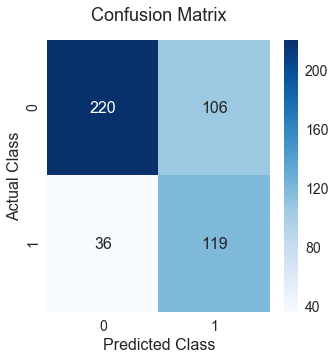

In [9]:
# saving best estimator from cross validation
ncc_model = mod.get_best_estimator(ncc_cv_results, greater_is_better=False)

# classification report for model on holdout data
ncc_y_pred = mod.holdout_evaluation(ncc_model, X_train, y_train, X_test, y_test, model_name='Nearest Centroid')

#### Model Performance Evaluation
The baseline model offers decent performance with with an __F1 score of 61%__. The model is also __decent at detecting loans that will default__, with a __recall of 77%__, but given the __low precision of 53%__, the model may be __over predicting defaults__. 

We will save the performance of our baseline and compare the results to other classification algorithms.

In [10]:
# saving model scores
ncc_results = mod.classification_scores(y_test, ncc_y_pred, model_name='NearestCentroid')
ncc_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263


In [11]:
# creating a results dataframe to compare models
model_results = ncc_results.copy(deep=True)

[Return to Table of Contents](#table_contents)

## K-Nearest Neighbours <a id='knn'></a>

KNN is a non-parametric method that assigns classes to observations based on the class majority of its k-nearest neighbours.

This model is also relatively simple to tune with __only one regularisation parameter k__, which is the number of neighbours to consider. 

However, as it is an instance-based learning techiques, it will be slower to evaluate predictions in production.

In [12]:
# creating dict of kwargs for GridSearchCV
gs_kwargs = dict((k, cv_kwargs[k]) for k in cv_kwargs if k != 'return_estimator')
gs_kwargs

{'scoring': 'f1',
 'cv': StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
 'n_jobs': -1,
 'return_train_score': True,
 'verbose': False}

In [13]:
# creating KNN model pipeline
knn_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

# KNN hyper parameters to iterate over
knn_param_grid = {
    'KNN__n_neighbors' : np.arange(2, 50, step=2),
}

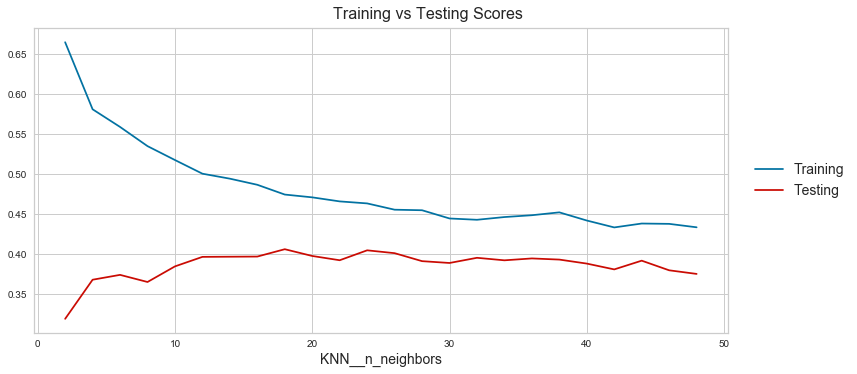

In [14]:
# average training and testing scores for KNN model for different hyper parameters 
mod.param_tuning_plots(knn_pipe, knn_param_grid, X_train, y_train, gs_kwargs, n_cols=1, figsize=(12,5))

#### Model Performance Interpretation
The figure shows that as `n_neighbours` start to increase beyound 25, the holdout performance deteriorates and the __model starts to overfit__. 

The optimal hyper parameter value appears to lie somewhere between 10 and 30 and we will iterate over this smaller range to find the best value.

In [15]:
# ppdated param gird with more hyper parameters
knn_param_grid = {
    'KNN__n_neighbors' : np.arange(10, 30, step=1),
    'KNN__weights' : ['uniform', 'distance'],
    'KNN__algorithm' : ['ball_tree', 'kd_tree', 'auto'],
    'KNN__metric' : ['euclidean', 'manhattan'],
    'KNN__n_jobs' : [-1]
}

In [16]:
# gridSearch to find the optimal hyper parameters 
knn_gscv = GridSearchCV(knn_pipe, knn_param_grid, **gs_kwargs)
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weig

In [17]:
# saving the best hyper parameters for KNN
knn_kwargs = dict((k[5:], knn_gscv.best_params_[k]) for k in knn_gscv.best_params_)
knn_kwargs

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_jobs': -1,
 'n_neighbors': 25,
 'weights': 'distance'}

Holdout Dataset Classification Report for Nearest Neighbours
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       326
           1       0.65      0.46      0.54       155

    accuracy                           0.75       481
   macro avg       0.71      0.67      0.68       481
weighted avg       0.73      0.75      0.73       481




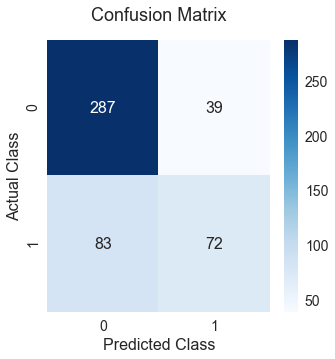

In [18]:
# saving best KNN estimator during GridSearch and evaluating on holdout data
knn_model = knn_gscv.best_estimator_
knn_y_pred = mod.holdout_evaluation(knn_model, X_train, y_train, X_test, y_test, model_name='Nearest Neighbours')

In [19]:
# saving KNN model performance on the holdout dataset
knn_results = mod.classification_scores(y_test, knn_y_pred, model_name='NearestNeighbour')

# appending results to results dataframe
model_results = model_results.append(knn_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414


#### Model Performance Interpretation
The K-Nearest Model has achieved an __F1 Score of 54%__, lower than the baseline model. We observe that the model has a __low recall of 46%__, which indicates that it is poor at identifying loans than will default. The model does have decent __precision of 65%__, which indicates that the predicted results are more reliable than the Nearest Centroid model.

[Return to Table of Contents](#table_contents)

## Logistic Regression <a id='logreg'></a>

Similar to the K-Nearest Neighbours model, the Logistic Regression also only has __one regularisation parameter lambda (C)__ to tune.

Furthermore, being a __parametric method__, it offers __great interpretability__ through analysing how the log-odds of default changes for each feature.

In [21]:
# creating logistic regression model and parameter grid to iterate over
logreg_kwargs = {
    'class_weight' : 'balanced',
    'penalty' : 'l2',
    'solver' : 'lbfgs',
    'max_iter' : 1000,
    'n_jobs' : -1,
    'random_state' : SEED
}

logreg_model = LogisticRegression(**logreg_kwargs)

logreg_param_grid = {
    'C' : np.logspace(-4,2,7)
}

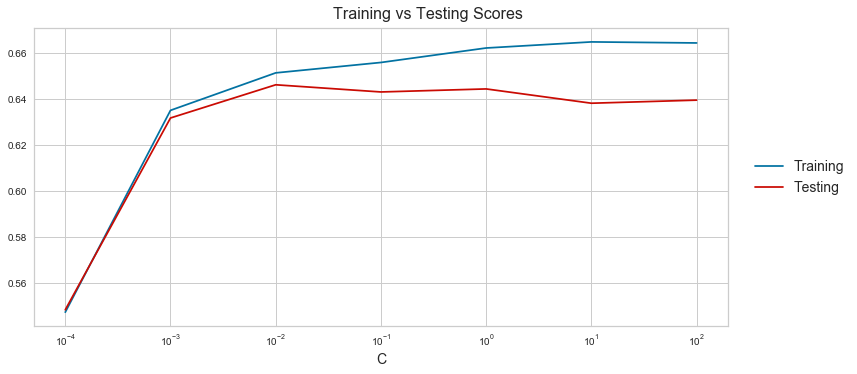

In [22]:
# average training and testing scores for different hyper parameter values
mod.param_tuning_plots(logreg_model, logreg_param_grid, X_train, y_train, gs_kwargs, n_cols=1,
                       x_axis_log_scale=True, figsize=(12,5))

The figure shows that as the as the regularisation parameter C increases to __greater than 1, the model starts to overfit__. 

__The optimal C appears to be somewhere around 0.01__. It seems that applying greater regularisation improves the model performance. We have narrowed our search space and will use a gridsearch to determine the optimal hyper parameter value.

In [33]:
# range of Cs to iterate over
logreg_param_grid = {
    'C' : np.arange(0.001, 0.1, step=0.002)
}

In [34]:
# gridsearch to find the optimal regularisation parameter C
logreg_gscv = GridSearchCV(logreg_model, logreg_param_grid, **gs_kwargs)
logreg_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=8888, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='dep...
             param_grid={'C': array([0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017,
       0.019, 0.021, 0.023, 0.025, 0.027, 0.029, 0.031, 0.033, 0.035,
       0.037, 0.039, 0.041, 0.043, 0.045, 0.047, 0.049, 0.051, 0.053,
       0.055, 0.057, 0.059, 0.061, 0.063, 0.065, 0.067

In [35]:
# updating our logisitc regression kwargs
logreg_kwargs['C'] = logreg_gscv.best_params_['C']
logreg_kwargs

{'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'max_iter': 1000,
 'n_jobs': -1,
 'random_state': 8888,
 'C': 0.013000000000000001}

Holdout Dataset Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       326
           1       0.53      0.75      0.63       155

    accuracy                           0.71       481
   macro avg       0.69      0.72      0.69       481
weighted avg       0.75      0.71      0.72       481




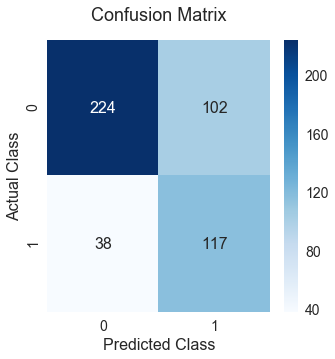

In [36]:
# saving the best estimator during GridSearch and getting evaluating on holdout data
logreg_model = logreg_gscv.best_estimator_
logreg_y_pred = mod.holdout_evaluation(logreg_model, X_train, y_train, X_test, y_test, model_name='Logistic Regression')

In [37]:
logreg_results = mod.classification_scores(y_test, logreg_y_pred, model_name='LogisticRegression')
model_results = model_results.append(logreg_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7048,0.7213,0.5289,0.7677,0.6263
1,NearestNeighbour,0.7464,0.6724,0.6486,0.4645,0.5414
2,LogisticRegression,0.7089,0.7210,0.5342,0.7548,0.6257


#### Model Performance Interpretation

The Logistic Regression has achieved an __F1 Score of 63%__, as well as similar precision and recall scores to the Baseline Nearest Centroid model.

Currently, the simpler Nearest Centoid model is performing the best out of the models we have tested but the results are not quite satisfactory yet. 

We will move on to trying more complex models.

[Return to Table of Contents](#table_contents)